## Third Approach: Re-sampling with SMOTE

In this approach, we will use the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm to balance the dataset. SMOTE generates synthetic samples for the minority class to balance the dataset. First, we will oversample the minority class **Enrolled**, then we will train a model using the balanced dataset. Additionally, we will perform other experiments, such as oversampling the other minority class **Dropout** and undersampling the majority class **Graduated**.

The SMOTE algorithm is described in the following paper: [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/index.php/jair/article/view/10302/24590). In this paper, the authors present the algorithm and demonstrate how this technique of oversampling the minority class is superior to traditional oversampling techniques, which simply duplicate the samples of the minority class.

Below is the pseudo-code for a two-class problem:

```julia
Algorithm SMOTE(T, N, k)
Input:
    T = Number of minority class samples
    N = Percentage of oversampling (SMOTE percentage)
    k = Number of nearest neighbors

Output:
    (N/100) * T synthetic minority class samples

1. If N is less than 100%, randomize the minority class samples, as only a random percentage of them will be SMOTEd.
2. If N < 100 then
    3. Randomize the T minority class samples
    4. T = (N / 100) * T
    5. N = 100
6. End if
7. N = (int)(N / 100) * T  (*The amount of SMOTE is assumed to be in integral multiples of 100.*)
8. k = Number of nearest neighbors
9. numattrs = Number of attributes
10. Sample[][]: Array for original minority class samples
11. newindex: Counter for number of synthetic samples, initialized to 0
12. Synthetic[][]: Array for synthetic samples

13. For i = 1 to T
    14. Compute k nearest neighbors for sample i, and save the indices in nnarray
    15. Populate(N, i, nnarray)
16. End for

Function Populate(N, i, nnarray):
17. While N > 0
    18. Choose a random number between 1 and k, call it nn. This step selects one of the k nearest neighbors of sample i.
    19. For each attribute (attr) from 1 to numattrs:
        20. Compute the difference: dif = Sample[nnarray[nn]][attr] - Sample[i][attr]
        21. Compute a random gap: gap = random number between 0 and 1
        22. Synthetic[newindex][attr] = Sample[i][attr] + gap * dif
    20. End for
    23. Increment newindex
    24. Decrement N
25. End while

26. Return synthetic samples
End of pseudo-code.
```


### Description of the used models

To be able to compare the results with the first and second approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


- Imbalanced-learn (revision): https://www.sciencedirect.com/science/article/pii/S0957417416307175?casa_token=lyglFt_Ye0YAAAAA:Apv_dixqX-GQm04rHLrN6wBhIRJHhxCFlqUS5WXXbuD-iJCO9FUBZ9VLAxgRDwUTKdpPTGgHIA
  - Aqui falan de SMOTE (tecnica para over-sampling), tecnicas de re-sampling híbridas e undersampling.
  - Tamén falan de que aplicando PCA e tecnicas de reducción da dimensionalidade se pode reducir o efecto negativo do desbalanceamento.
  - Tamén comentan que as técnicas de ensamblado se utilizan para estas situacións, pero me da que non vai poder ser aplicable ao noso caso (utilizan AdaBoost e esas vainas).
  - Por último, comentan que se poden utilizar técnicas para ponderar os erros. Guai se utilizamos unha rede neuronal, posto que so hai que cambiar a función de custo, pero implementa ti isto en SVM ou Decision Tree. É posible, de feito, hai formas e explicanse, pero implicaría cambiar o codigo drasticamente.
- Learning from imbalanced data (non o lin, pero creo que tamén describe técnicas de resampling): https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907


**Index**

- [Data loading](#Data-loading)
- [SMOTE experiments](#SMOTE-experiments)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading


In [1]:
using DataFrames
using CSV
using Random
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 2 methods)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame);

# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [4]:
inputs = Float32.(Matrix(inputs))

# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## SMOTE experiments

In the first approach we see that we detected some problems in some metrics because of the imbalance of the dataset. For example, for the ANN model, we get high values of mean accuracy and low values of mean F1-score. This happens because the precision and recall of the class `Enrolled` are very low.

<div style="display: flex; justify-content: center;">
<image src="plots/Approach1/ANN/accuracy_performance_bar.png" width="600"/>
<image src="plots/Approach1/ANN/f1_score_performance_bar.png" width="600"/>
</div>

To address this problem, we will use the SMOTE algorithm to balance the dataset. We will conduct 5 experiments:

- Oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Enrolled` at 200% and undersampling the majority class `Graduated` at 50%.

We are going to fix the number of nearest neighbors to 5.

To avoid retraining all the models multiple times, we will perform the experiments only with the base models: ANN, Decision Tree, SVM, and KNN, using the best hyperparameters identified in the first approach. Subsequently, we will train the models in the same manner as in the first approach, but with the balanced dataset that yielded the best results.


In [5]:
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


In [15]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String, Int64}()
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588

Smote percentages: Dict{String, Int64}()
Number of instances: 4424
Elements of class Dropout: 1421
Elemen

In [26]:
# Best configurations
topology = [32, 16]
topology_scikit_ann = [16, 16]
max_depth = 5
n_neighbors = 15
kernel = "linear"
C = 0.1

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String, Int64}()
];

In [27]:
Random.seed!(42)

general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN
Mean accuracy: 0.50822 ± 0.02835
	Class 1: 0.43097 ± 0.0419
	Class 2: 0.46566 ± 0.02078
	Class 3: 0.76491 ± 0.04178
Mean precision: 0.18839 ± 0.04102
	Class 1: 0.19945 ± 0.01794
	Class 2: 0.22018 ± 0.08935
	Class 3: 0.08006 ± 0.03701
Mean recall: 0.33077 ± 0.04648
	Class 1: 0.52037 ± 0.08918
	Class 2: 0.29361 ± 0.15447
	Class 3: 0.09471 ± 0.06964
Mean f1_score: 0.20975 ± 0.0385
	Class 1: 0.27352 ± 0.03961
	Class 2: 0.22239 ± 0.10223
	Class 3: 0.06032 ± 0.02927
scikitANN
Mean accuracy: 0.83491 ± 0.00627
	Class 1: 0.83475 ± 0.01537
	Class 2: 0.8449 ± 0.00847
	Class 3: 0.82219 ± 0.005
Mean precision: 0.72471 ± 0.00943
	Class 1: 0.76927 ± 0.01832
	Class 2: 0.76085 ± 0.01855
	Class 3: 0.51849 ± 0.03203
Mean recall: 0.75092 ± 0.00711
	Class 1: 0.87735 ± 0.05777
	Class 2: 0.78709 ± 0.04023
	Class 3: 0.25969 ± 0.06684
Mean f1_score: 0.72434 ± 0.00886
	Class 1: 0.81695 ± 0.03024
	Class 2: 0.77019 ± 0.02295
	Class 3: 0.33692 ± 0.05842
DT
Mean accura

### Save the results and analysis


In [28]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200, 100], "Dropout" => [100, 100, 200, 200, 100, 100], "Graduate" => [100, 100, 100, 100, 50, 100])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [29]:
results_folder = "results/"
filename = results_folder * "3_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

Dict{Symbol, Dict{String, Any}} with 5 entries:
  :DT         => Dict("class_results"=>Any[[Dict(:recall=>[0.950226, 0.925339, …
  :KNN        => Dict("class_results"=>Any[[Dict(:recall=>[0.864253, 0.877828, …
  :SVM        => Dict("class_results"=>Any[[Dict(:recall=>[0.750877, 0.78169, 0…
  :scikit_ANN => Dict("class_results"=>Any[[Dict(:recall=>[0.899792, 0.817484, …
  :ANN        => Dict("class_results"=>Any[[Dict(:recall=>[0.670175, 0.454225, …

In [30]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/smote/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 100, Graduate: 100, Dropout: 100 │ 0.841457 │   0.75336 │ 0.760452 │ 0.745818 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.824279 │  0.700295 │ 0.737853 │ 0.696531 │
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.821899 │  0.691041 │ 0.733333 │ 0.686796 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │ 0.689202 │   0.64063 │ 0.545763 │ 0.458252 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │ 0.654276 │  0.648208 │ 0.531073 │ 0.419657 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.591261 │  0.633994 │ 0.414496 │ 0.377558 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Result

Based on the results presented in the tables, the best SMOTE configuration involves oversampling the minority class, `Enrolled`, by 300%, while keeping the majority class, `Graduated`, and the other class, `Dropout`, unchanged. This conclusion is drawn from the mean F1-score, the metric of primary interest in this analysis.

However, it is important to highlight that, except for the KNN model, applying SMOTE tends to degrade the performance compared to the initial approach without balancing the dataset. This decline can be attributed to the synthetic samples generated by the SMOTE algorithm, which may introduce noise rather than meaningful information for balancing the dataset. This underscores a critical limitation of SMOTE: its effectiveness is highly dependent on the characteristics of the dataset and the specific models used.

Another noteworthy point is the dataset's high dimensionality, which may lead SMOTE to generate synthetic samples that fail to benefit the models. High dimensionality can obscure meaningful patterns and hinder the generation of useful synthetic data. As a potential improvement, applying feature selection techniques to reduce the number of attributes before applying SMOTE could lead to better outcomes. This refined approach will be explored in the next steps of the analysis.


## Individual models

Next, we will train the individual models with the best hyperparameters identified in the first approach, but using the balanced dataset that yielded the best results in the SMOTE experiments.

### ANN

We are going to use the our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 10 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [31]:
# Set the random seed for reproducibility
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.68417 ± 0.18855
	Class 1: 0.71477 ± 0.19098
	Class 2: 0.66089 ± 0.199
	Class 3: 0.69411 ± 0.16114
Mean precision: 0.52847 ± 0.24255
	Class 1: 0.55944 ± 0.30005
	Class 2: 0.5757 ± 0.25037
	Class 3: 0.34156 ± 0.13927
Mean recall: 0.53488 ± 0.2735
	Class 1: 0.54822 ± 0.30401
	Class 2: 0.59818 ± 0.42331
	Class 3: 0.33482 ± 0.21016
Mean f1_score: 0.49713 ± 0.28732
	Class 1: 0.53609 ± 0.32435
	Class 2: 0.55596 ± 0.36646
	Class 3: 0.26369 ± 0.06717
Training ANN with topology: [32]
Mean accuracy: 0.57688 ± 0.14319
	Class 1: 0.55231 ± 0.17623
	Class 2: 0.55362 ± 0.1529
	Class 3: 0.68563 ± 0.08793
Mean precision: 0.38416 ± 0.17695
	Class 1: 0.35641 ± 0.24312
	Class 2: 0.46624 ± 0.18175
	Class 3: 0.20555 ± 0.07378
Mean recall: 0.39578 ± 0.19511
	Class 1: 0.45581 ± 0.20155
	Class 2: 0.40458 ± 0.31105
	Class 3: 0.26397 ± 0.13534
Mean f1_score: 0.33794 ± 0.21058
	Class 1: 0.37075 ± 0.23355
	Class 2: 0.37014 ± 0.27695
	Class 3: 0.18979 ± 0.05897
Train

## ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [32]:
# Set the random seed for reproducibility
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.83505 ± 0.00582
	Class 1: 0.83593 ± 0.01037
	Class 2: 0.84304 ± 0.00946
	Class 3: 0.81998 ± 0.00734
Mean precision: 0.726 ± 0.01002
	Class 1: 0.76084 ± 0.03061
	Class 2: 0.75667 ± 0.03345
	Class 3: 0.52156 ± 0.03465
Mean recall: 0.74947 ± 0.00752
	Class 1: 0.84456 ± 0.06768
	Class 2: 0.76958 ± 0.05163
	Class 3: 0.33046 ± 0.06771
Mean f1_score: 0.72905 ± 0.0094
	Class 1: 0.79746 ± 0.04637
	Class 2: 0.75935 ± 0.03698
	Class 3: 0.39653 ± 0.05721
Training ANN with topology: [32]
Mean accuracy: 0.83401 ± 0.00759
	Class 1: 0.83342 ± 0.01272
	Class 2: 0.84286 ± 0.00295
	Class 3: 0.81896 ± 0.00732
Mean precision: 0.72206 ± 0.01234
	Class 1: 0.76013 ± 0.01664
	Class 2: 0.76118 ± 0.0207
	Class 3: 0.50371 ± 0.04093
Mean recall: 0.74762 ± 0.0095
	Class 1: 0.86127 ± 0.04316
	Class 2: 0.77551 ± 0.05124
	Class 3: 0.29039 ± 0.05267
Mean f1_score: 0.72473 ± 0.01149
	Class 1: 0.80589 ± 0.02299
	Class 2: 0.764 ± 0.03024
	Class 3: 0.36075 ± 0.05037
Trainin

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [33]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.82098 ± 0.00787
	Class 1: 0.81803 ± 0.02407
	Class 2: 0.82889 ± 0.02407
	Class 3: 0.81554 ± 0.02844
Mean precision: 0.73083 ± 0.01257
	Class 1: 0.77224 ± 0.03368
	Class 2: 0.74476 ± 0.16579
	Class 3: 0.53349 ± 0.18216
Mean recall: 0.73124 ± 0.0101
	Class 1: 0.86233 ± 0.08844
	Class 2: 0.65608 ± 0.13301
	Class 3: 0.44091 ± 0.15518
Mean f1_score: 0.72405 ± 0.01272
	Class 1: 0.81145 ± 0.03138
	Class 2: 0.69373 ± 0.13476
	Class 3: 0.47729 ± 0.16253
Training DT model with max_depth: 5
Mean accuracy: 0.83244 ± 0.0094
	Class 1: 0.81554 ± 0.01546
	Class 2: 0.86144 ± 0.00999
	Class 3: 0.82753 ± 0.00337
Mean precision: 0.74036 ± 0.00854
	Class 1: 0.74623 ± 0.02038
	Class 2: 0.84364 ± 0.01498
	Class 3: 0.53919 ± 0.02112
Mean recall: 0.75226 ± 0.01018
	Class 1: 0.957 ± 0.00997
	Class 2: 0.69877 ± 0.04595
	Class 3: 0.27823 ± 0.07686
Mean f1_score: 0.72876 ± 0.01398
	Class 1: 0.83837 ± 0.01067
	Class 2: 0.76348 ± 0.02519
	Class 3: 0.36155 ± 0.0676

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [34]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.83962 ± 0.00539
	Class 1: 0.8395 ± 0.01913
	Class 2: 0.84653 ± 0.02051
	Class 3: 0.82707 ± 0.02465
Mean precision: 0.74241 ± 0.00619
	Class 1: 0.78361 ± 0.01855
	Class 2: 0.75595 ± 0.14327
	Class 3: 0.55438 ± 0.16093
Mean recall: 0.75655 ± 0.00675
	Class 1: 0.85438 ± 0.10005
	Class 2: 0.72116 ± 0.24129
	Class 3: 0.4143 ± 0.18178
Mean f1_score: 0.74245 ± 0.00726
	Class 1: 0.81433 ± 0.03901
	Class 2: 0.73047 ± 0.1869
	Class 3: 0.47234 ± 0.1759
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.83945 ± 0.00589
	Class 1: 0.8334 ± 0.01151
	Class 2: 0.85331 ± 0.01825
	Class 3: 0.82459 ± 0.02355
Mean precision: 0.74119 ± 0.00739
	Class 1: 0.77753 ± 0.00814
	Class 2: 0.76344 ± 0.13763
	Class 3: 0.54584 ± 0.15975
Mean recall: 0.75565 ± 0.00756
	Class 1: 0.88694 ± 0.08358
	Class 2: 0.68886 ± 0.21024
	Class 3: 0.41356 ± 0.17949
Mean f1_score: 0.742 ± 0.0076
	Class 1: 0.82702 ± 0.03878
	Class 2: 0.71941 ± 0.17294
	C

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [35]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        verbose=false,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77892 ± 0.00717
	Class 1: 0.77801 ± 0.03267
	Class 2: 0.78031 ± 0.02278
	Class 3: 0.79249 ± 0.01916
Mean precision: 0.66569 ± 0.00887
	Class 1: 0.72281 ± 0.01793
	Class 2: 0.6563 ± 0.1528
	Class 3: 0.45623 ± 0.17364
Mean recall: 0.6754 ± 0.00918
	Class 1: 0.76213 ± 0.08803
	Class 2: 0.64115 ± 0.19731
	Class 3: 0.38993 ± 0.15663
Mean f1_score: 0.66803 ± 0.00838
	Class 1: 0.74034 ± 0.04835
	Class 2: 0.64633 ± 0.17121
	Class 3: 0.42006 ± 0.16456
Training KNN model with n_neighbors: 3
Mean accuracy: 0.78421 ± 0.00707
	Class 1: 0.77665 ± 0.02083
	Class 2: 0.79568 ± 0.02752
	Class 3: 0.78254 ± 0.02141
Mean precision: 0.67738 ± 0.01189
	Class 1: 0.73988 ± 0.01063
	Class 2: 0.66624 ± 0.18803
	Class 3: 0.44849 ± 0.17526
Mean recall: 0.67743 ± 0.01101
	Class 1: 0.78488 ± 0.08882
	Class 2: 0.61503 ± 0.17276
	Class 3: 0.41783 ± 0.12252
Mean f1_score: 0.67469 ± 0.0096
	Class 1: 0.76004 ± 0.04791
	Class 2: 0.63736 ± 0.17445
	Class 3: 0.43117 ± 

### Save the results

The filename with the results of individual models of this first approach will be `3_individual_results.jl`.


In [36]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [37]:
results_folder = "results/"
filename = results_folder * "3_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

#  As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 6

Model 1: max_depth: 3, 
Mean recall: 0.73124 ± 0.0101
	Class 1: 0.86233
	Class 2: 0.65608
	Class 3: 0.44091
Mean f1_score: 0.72405 ± 0.01272
	Class 1: 0.81145
	Class 2: 0.69373
	Class 3: 0.47729
Mean precision: 0.73083 ± 0.01257
	Class 1: 0.77224
	Class 2: 0.74476
	Class 3: 0.53349
Mean accuracy: 0.82098 ± 0.00787
	Class 1: 0.81803
	Class 2: 0.82889
	Class 3: 0.81554

Model 2: max_depth: 5, 
Mean recall: 0.75226 ± 0.01018
	Class 1: 0.957
	Class 2: 0.69877
	Class 3: 0.27823
Mean f1_score: 0.72876 ± 0.01398
	Class 1: 0.83837
	Class 2: 0.76348
	Class 3: 0.36155
Mean precision: 0.74036 ± 0.00854
	Class 1: 0.74623
	Class 2: 0.84364
	Class 3: 0.53919
Mean accuracy: 0.83244 ± 0.0094
	Class 1: 0.81554
	Class 2: 0.86144
	Class 3: 0.82753

Model 3: max_depth: 10, 
Mean recall: 0.72174 ± 0.01226
	Class 1: 0.8254
	Class 2: 0.74053
	Class 3: 0.36521
Mean f1_score: 0.71523 ± 0.01348
	Class 1: 0.80606
	Class 2: 0.74487
	Class 3: 0.39356
Mean precision: 0.712

### Plots for base models


In [39]:
# Aggregate metrics
model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, output_dir="./plots/Approach3/")
# Plot metrics for each class
plotMetricsAlgorithm(loaded_obj, 3, output_dir="./plots/Approach3/Classes")

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.
Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Clas

In [40]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.840894 │   0.75336 │ 0.760452 │ 0.745818 │
│       max_depth: 3 │ 0.834862 │   0.75264 │ 0.746893 │ 0.745743 │
│      max_depth: 10 │ 0.823998 │  0.727392 │ 0.732203 │ 0.725924 │
│      max_depth: 15 │ 0.816084 │  0.723453 │ 0.722034 │ 0.722562 │
│ max_depth: nothing │ 0.803778 │  0.713862 │ 0.706215 │ 0.709625 │
│      max_depth: 20 │ 0.801179 │   0.70093 │ 0.697517 │ 0.698352 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach3/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

In [ ]:
# Generate tables for each algorithm for each class sorted by f1 score
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/class")


Comparison of Hyperparameter Configurations for DT on Class 1 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.815545 │  0.746226 │    0.957 │ 0.838368 │
│       max_depth: 3 │ 0.818033 │  0.772236 │ 0.862326 │ 0.811448 │
│      max_depth: 10 │ 0.820063 │  0.790462 │ 0.825402 │ 0.806062 │
│      max_depth: 15 │ 0.797226 │  0.767101 │ 0.790988 │ 0.778695 │
│ max_depth: nothing │ 0.776886 │   0.78192 │ 0.767772 │ 0.774662 │
│      max_depth: 20 │ 0.791574 │  0.748316 │ 0.749615 │ 0.748864 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT on Class 1 saved to ./tables/Approach3/Classes.

Comparison of Hyperparameter Configurations for DT on Class 2 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuratio

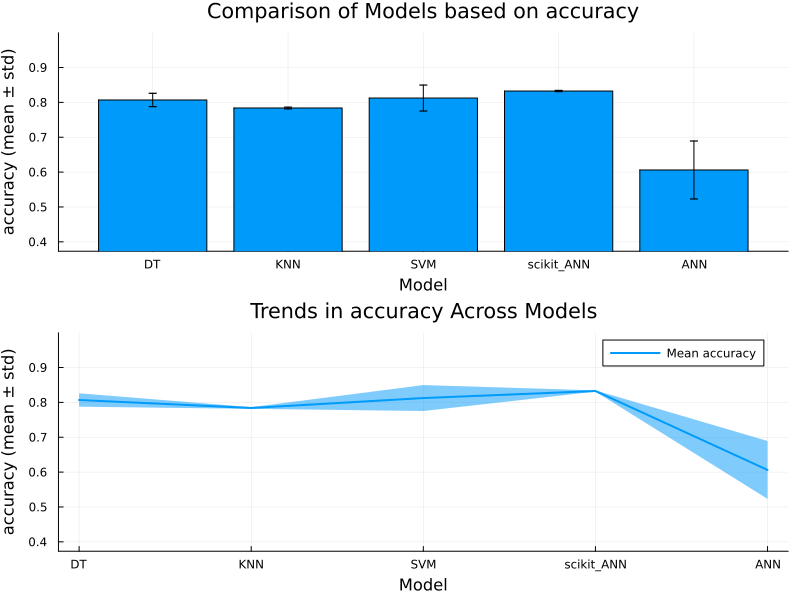

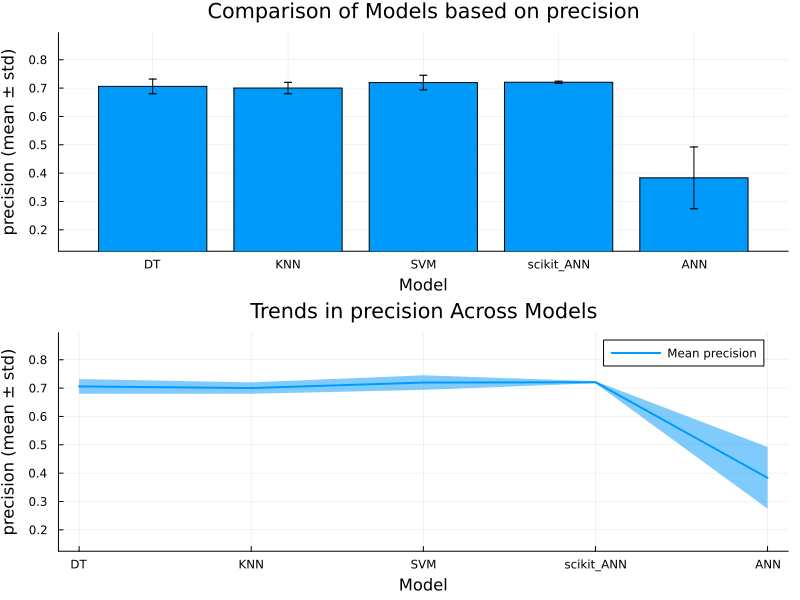

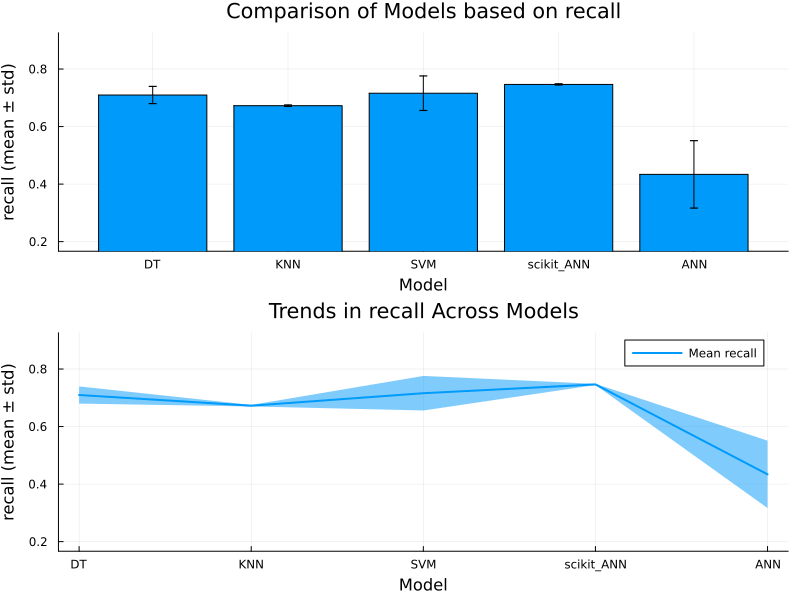

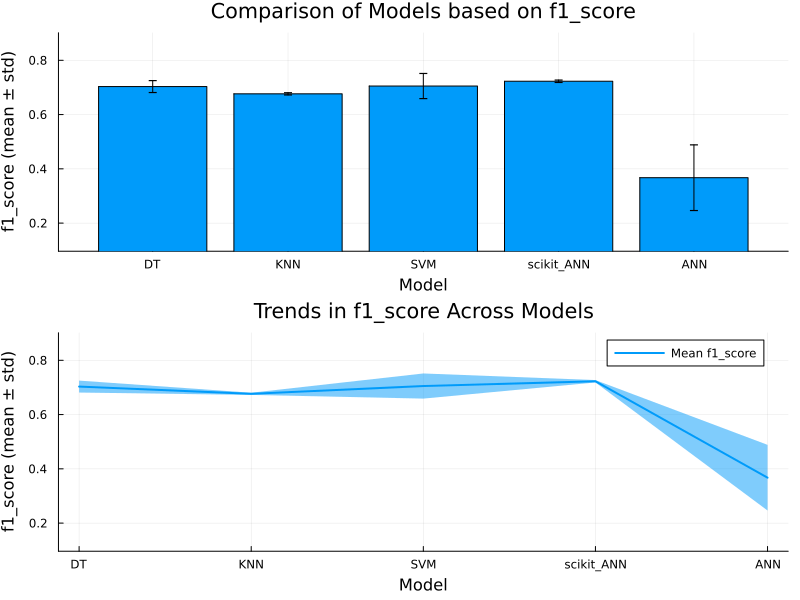

In [42]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach3/", show=true)

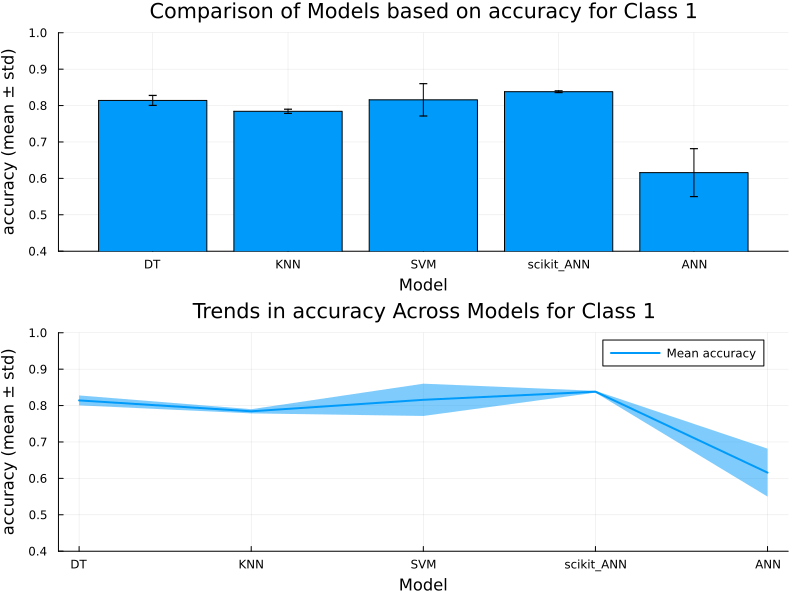

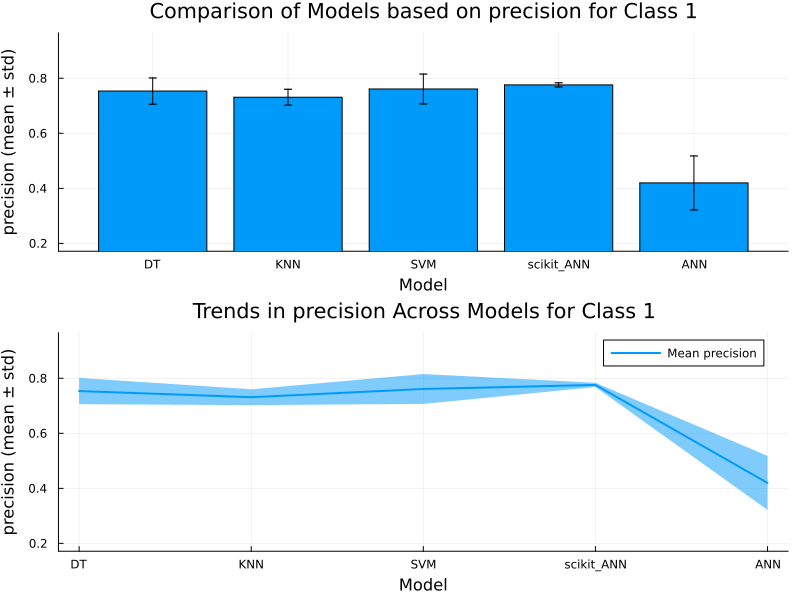

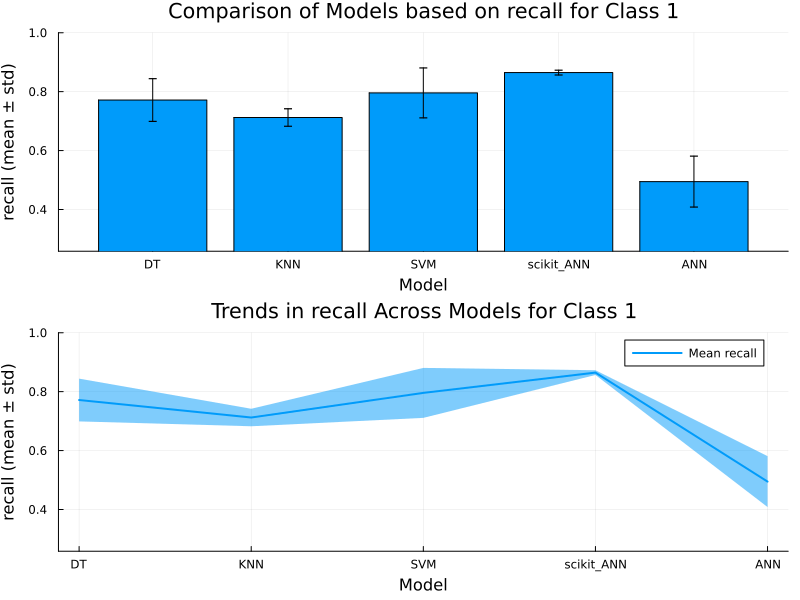

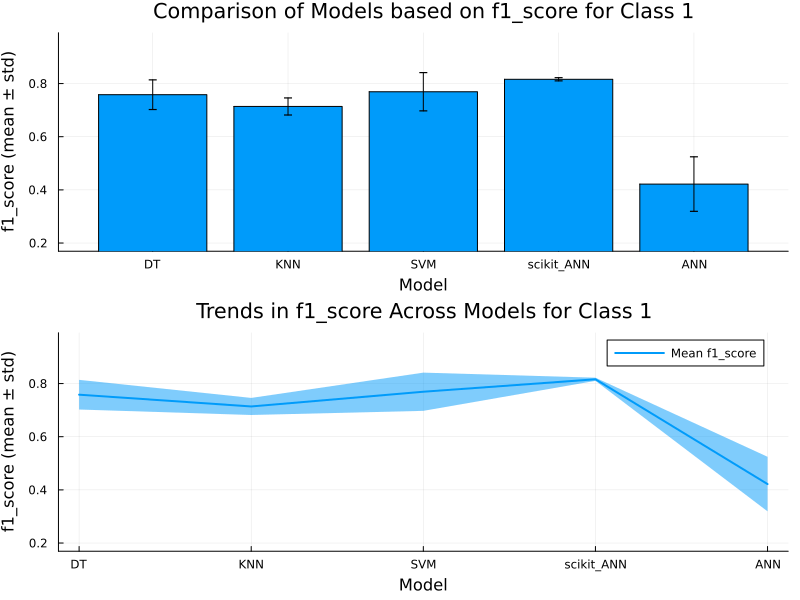

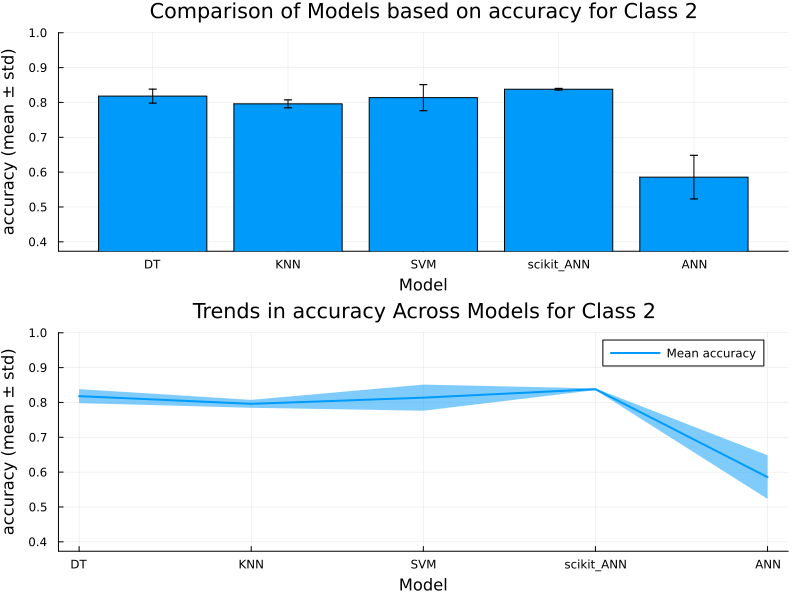

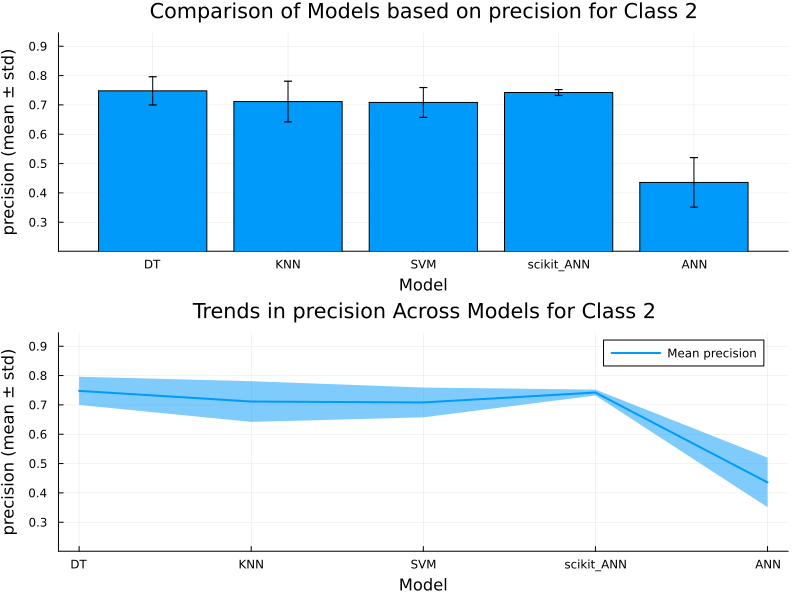

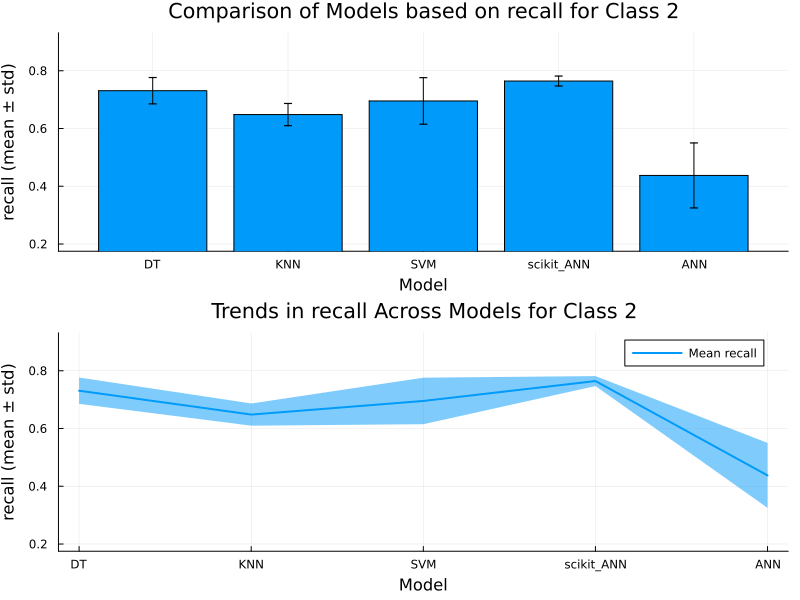

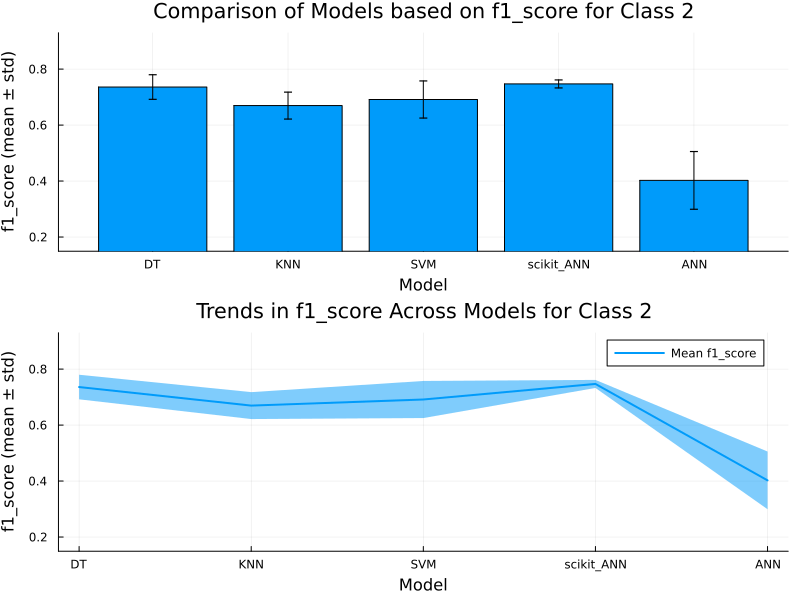

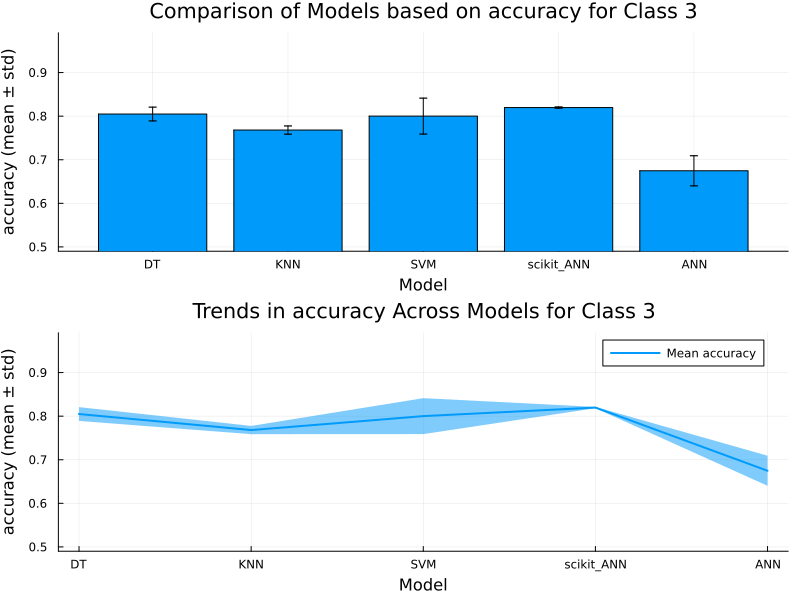

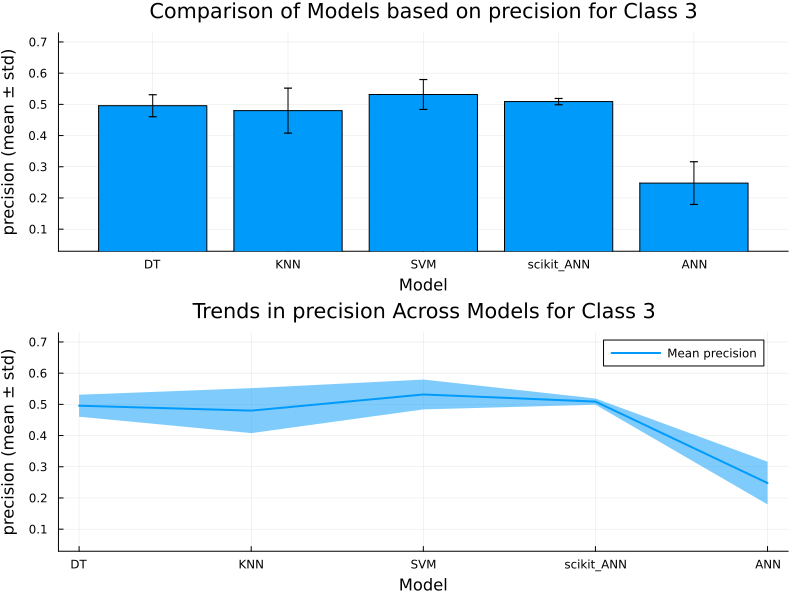

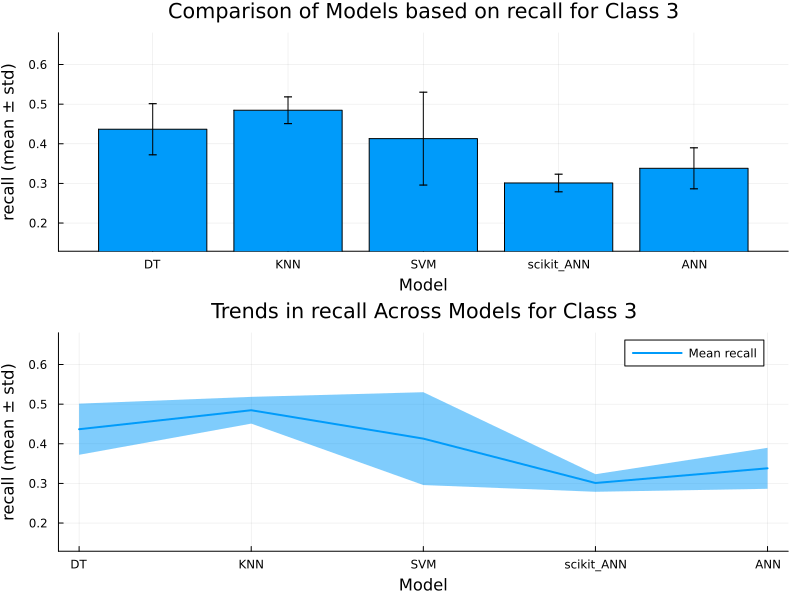

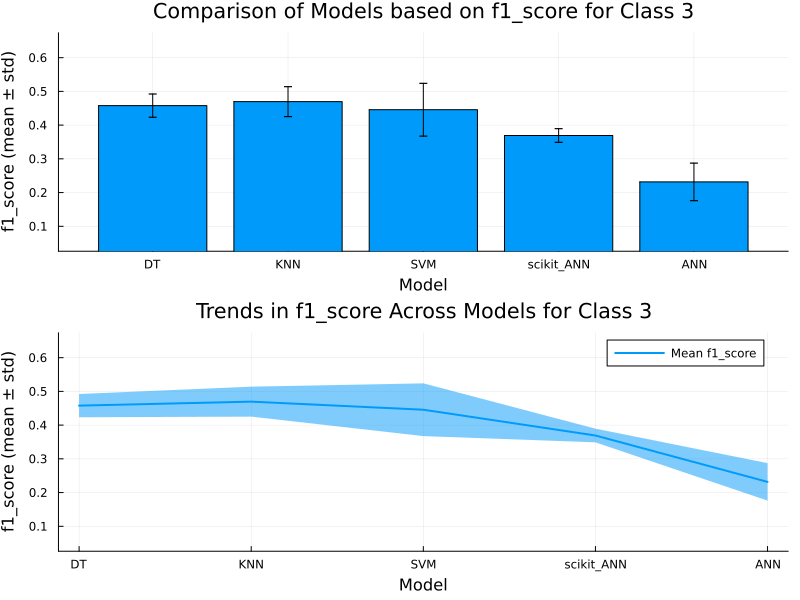

In [ ]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir="./plots/Approach3/class", show=true)

In [49]:
# Generate and print the overall comparison table (selecting the best model for each metric)
generateComparisonTable(model_names, metrics, metric_maxes; output_dir="./tables/Approach3/", sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.848 │      0.76 │  0.766 │    0.755 │
│ scikit_ANN │    0.846 │     0.744 │  0.765 │    0.745 │
│         DT │    0.841 │     0.753 │   0.76 │    0.746 │
│        ANN │    0.832 │     0.725 │  0.746 │     0.73 │
│        KNN │      0.8 │     0.732 │  0.696 │    0.703 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [50]:
# Generate and print the overall comparison table by class (selecting the best model for each metric)
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; output_dir="./tables/Approach3/class", sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.864 │     0.874 │  0.957 │    0.855 │
│        ANN │    0.863 │     0.788 │  0.805 │    0.791 │
│         DT │    0.854 │      0.82 │  0.971 │    0.849 │
│ scikit_ANN │    0.851 │     0.795 │  0.941 │    0.853 │
│        KNN │    0.835 │     0.897 │  0.876 │    0.807 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Maximum Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.875 │     0.903 │  0.939 │    0.863 │
│         DT │    0.869 │     0.875 │  0.878 │    0.826 │
│ scikit_ANN │    0.857 │     

### Conclusions

In general, applying SMOTE did not yield better results compared to the first approach. Additionally, this approach resulted in extremely high variance for the ANN model, which is undesirable. The following figure illustrates the mean F1-scores for individual models:

<div style="display: flex; justify-content: center;">
  <image src="plots/Approach3/combined_f1_score_plots.png" width="600"/>
</div>

To provide a clearer comparison, the tables below summarize the highest metric values achieved by each model in the first and third approaches:

**Table: Best Values per Model and Metric in the First Approach**
| Model | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM | 0.855 | 0.769 | 0.78 | 0.767 |
| ANN | 0.854 | 0.761 | 0.776 | 0.764 |
| scikit_ANN | 0.853 | 0.763 | 0.776 | 0.765 |
| DT | 0.841 | 0.753 | 0.76 | 0.746 |
| KNN | 0.815 | 0.721 | 0.732 | 0.705 |

**Table: Best Values per Model and Metric in the Third Approach**
| Model | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM | 0.849 | 0.768 | 0.772 | 0.759 |
| scikit_ANN | 0.845 | 0.745 | 0.764 | 0.746 |
| DT | 0.841 | 0.759 | 0.763 | 0.749 |
| ANN | 0.841 | 0.735 | 0.756 | 0.737 |
| KNN | 0.813 | 0.741 | 0.716 | 0.719 |

We observe that the differences between the tables are minimal, with the best F1-scores for the third approach being slightly lower than those of the first approach (except for KNN). This result suggests that the SMOTE algorithm did not significantly improve the models' performance. The high dimensionality of the dataset may have contributed to this outcome, as generating synthetic samples with SMOTE in high-dimensional spaces can be challenging.

The primary objective of this approach was to improve model performance for the third class, `Enrolled`, with the goal of achieving overall better performance. The following plots compare the F1-scores for the `Enrolled` class across the first and third approaches. While there was a slight improvement in the performance for Enrolled, this improvement came at the cost of a small decline in performance for the other classes.

<div style="display: flex; justify-content: center;">
  <image src="plots/Approach1/Classes/combined_f1_score_plots_class_3.png" width="600"/>
  <image src="plots/Approach3/Classes/combined_f1_score_plots_class_3.png" width="600"/>
</div>


## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


In [ ]:
# Select the best models
estimators = [:ANN, :SVC, :DT]
hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (16, 16),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
    :kernel => "poly",
    :C => 1.0,
    :gamma => "auto",
    :probability => true,
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
)])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.2, 0.3]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

In [ ]:
for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets_label_encoded),
        fold_indices;
        ensembleType = ensemble[:type],
        ensembleHyperParameters = ensemble[:hyperparameters],
        metricsToSave = metrics_to_save,
        verbose = false,
        repetitionsTraining = 5,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.83703 ± 0.00579
	Class 1: 0.84357 ± 0.02395
	Class 2: 0.84206 ± 0.01537
	Class 3: 0.82794 ± 0.0072
Mean precision: 0.74161 ± 0.00715
	Class 1: 0.78748 ± 0.03462
	Class 2: 0.7942 ± 0.0237
	Class 3: 0.53867 ± 0.03465
Mean recall: 0.75678 ± 0.00884
	Class 1: 0.83071 ± 0.0989
	Class 2: 0.83565 ± 0.1185
	Class 3: 0.31053 ± 0.03379
Mean f1_score: 0.73844 ± 0.00879
	Class 1: 0.80418 ± 0.03314
	Class 2: 0.80904 ± 0.04812
	Class 3: 0.39179 ± 0.02809
------------------------------------
Training ensemble Voting
Mean accuracy: 0.83482 ± 0.00517
	Class 1: 0.83756 ± 0.02194
	Class 2: 0.8445 ± 0.01688
	Class 3: 0.82491 ± 0.00554
Mean precision: 0.73796 ± 0.00624
	Class 1: 0.78469 ± 0.03797
	Class 2: 0.79619 ± 0.02925
	Class 3: 0.52397 ± 0.02694
Mean recall: 0.75348 ± 0.0075
	Class 1: 0.84543 ± 0.09821
	Class 2: 0.81506 ± 0.10856
	Class 3: 0.30125 ± 0.01785
Mean f1_score: 0.73466 ± 0.00733
	Class 1: 0.80878 ± 0.03065
	Class 2: 0.79992 ± 0.04047
	Class 3: 0.38

In [ ]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end